In [1]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from add_features import medication_score, add_tweet_info
import eli5



### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [2]:
df_train = pd.read_csv('task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('task1_testing.csv', delimiter = '\t')


In [3]:
print(len(df_train))
print(len(df_test))

55419
13853


In [4]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13817
1       36
Name: count, dtype: int64


### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [5]:
from process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

#### Tokenization + lemmatization

In [6]:
from process import lemma_tokenizer

lemma_tokenizer(df_train, 'tweet')
lemma_tokenizer(df_test, 'tweet')

#### Remoçao de stopwords

In [7]:
from process import remove_stopwords

remove_stopwords(df_train, 'tweet')
remove_stopwords(df_test, 'tweet')

### Geração de novas features

Serão acrescentadas posteriormente à matriz do tfidf

In [8]:
medication_score(df_train,'medication_list.txt')
medication_score(df_test,'medication_list.txt')


,tweet_id,user_id,tweet,created_at,label,medication_score
0,502548414362841091,445019339,"[caydens, already, starting, open, eye, !, ane...",2014-08-21,0,0
1,557183572713676800,1485346748,"[johnny, cash, kind, mornin]",2015-01-19,0,0
2,442493939493261313,285855751,[chest],2014-03-09,0,0
3,499670327299805186,2421157857,"[sumn, slight]",2014-08-13,0,0
4,667265159753170944,1087305673,"[never, ever, excited, see, adelanto, .]",2015-11-19,0,0
...,...,...,...,...,...,...
13848,765601444678475778,1143892999,[go],2016-08-16,0,0
13849,821462917086183425,4745862650,"[jamie, foxx, movie, wa, coo, ,, see, relation...",2017-01-17,0,0
13850,870832539094491136,429115374,"[always, protect, son, ,, ill, damned, anyone,...",2017-06-03,0,0
13851,648522498984816640,1465089974,"[baby, kicking, strong, past, day, adriene, fi...",2015-09-28,0,0


### TF-IDF

In [9]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [10]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [11]:
def dummy_tokenizer(text):
    return text

In [12]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

In [13]:
tfidf

TfidfVectorizer(lowercase=False, stop_words='english',
                tokenizer=<function dummy_tokenizer at 0x000001F1E72F4DC0>)

In [14]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


#### Adicionar medication_scores ao tfidf

In [15]:
import scipy as sp
#add medication score
new_train = [[x] for x in df_train['medication_score'].tolist()]
new_test = [[x] for x in df_test['medication_score'].tolist()]

X_train_tfidf = sp.sparse.hstack((X_train_tfidf, new_train))
X_test_tfidf = sp.sparse.hstack((X_test_tfidf, new_test))

### SVM

In [16]:
param_grid = {'C': [1,10,100],
              'loss': ['hinge','squared_hinge'],
              'class_weight':['balanced',None]
              }

scorer = make_scorer(f1_score, pos_label=1)

grid_svm = GridSearchCV(LinearSVC(max_iter=10000),param_grid, verbose=3, cv=5, scoring=scorer)
grid_svm.fit(X_train_tfidf, y_train)
y_pred_grid_svm = grid_svm.predict(X_test_tfidf)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, class_weight=balanced, loss=hinge;, score=0.667 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, loss=hinge;, score=0.654 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, loss=hinge;, score=0.583 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, loss=hinge;, score=0.655 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, loss=hinge;, score=0.717 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.691 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.720 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.583 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.643 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.745 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, loss=hinge;,

In [17]:
best_est = grid_svm.best_estimator_
best_scores = grid_svm.cv_results_['mean_test_score'][grid_svm.best_index_]
print(best_scores)

0.6764395212630507


In [18]:
print(grid_svm.best_params_)
print(classification_report(y_test,y_pred_grid_svm))

{'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.87      0.75      0.81        36

    accuracy                           1.00     13853
   macro avg       0.94      0.87      0.90     13853
weighted avg       1.00      1.00      1.00     13853



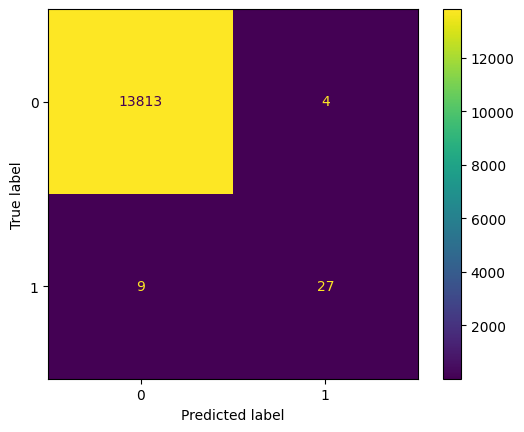

In [19]:
cm = confusion_matrix(y_test, y_pred_grid_svm, labels=grid_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_svm.classes_)
disp.plot()

In [20]:
print("Valores previstos: ", list(y_pred_grid_svm))
print("Valores reais: " , list(y_test))
print('========================================')
print('Tweets errados:')
index = -1
for x,y in zip(list(y_pred_grid_svm), list(y_test)):
    index +=1
    if x != y:
        print(df_test.tweet[index])

Valores previstos:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Random forest

In [23]:
param_grid = {'n_estimators':[200, 500, 1000],
              'class_weight':['balanced'],
              'max_depth': [3,6,9,None]
              }

scorer = make_scorer(f1_score, pos_label=1)

grid_rf = GridSearchCV(RandomForestClassifier(),param_grid, verbose=3, cv=5, scoring=scorer)
grid_rf.fit(X_train_tfidf, y_train)
y_pred_grid_rf = grid_rf.predict(X_test_tfidf)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END class_weight=balanced, max_depth=3, n_estimators=200;, score=0.462 total time=   3.5s
[CV 2/5] END class_weight=balanced, max_depth=3, n_estimators=200;, score=0.439 total time=   3.5s
[CV 3/5] END class_weight=balanced, max_depth=3, n_estimators=200;, score=0.235 total time=   3.5s
[CV 4/5] END class_weight=balanced, max_depth=3, n_estimators=200;, score=0.286 total time=   3.5s
[CV 5/5] END class_weight=balanced, max_depth=3, n_estimators=200;, score=0.333 total time=   3.5s
[CV 1/5] END class_weight=balanced, max_depth=3, n_estimators=500;, score=0.327 total time=   8.9s
[CV 2/5] END class_weight=balanced, max_depth=3, n_estimators=500;, score=0.565 total time=   8.9s
[CV 3/5] END class_weight=balanced, max_depth=3, n_estimators=500;, score=0.333 total time=   8.9s
[CV 4/5] END class_weight=balanced, max_depth=3, n_estimators=500;, score=0.429 total time=   9.0s
[CV 5/5] END class_weight=balanced, max_depth=3,

In [25]:
print(grid_rf.best_estimator_)
print(classification_report(y_test,y_pred_grid_rf))

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=500)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.65      0.36      0.46        36

    accuracy                           1.00     13853
   macro avg       0.82      0.68      0.73     13853
weighted avg       1.00      1.00      1.00     13853



In [31]:
best_est = grid_rf.best_estimator_
best_scores = grid_rf.cv_results_['mean_test_score'][grid_rf.best_index_]
print(best_scores)

0.4510852468490466


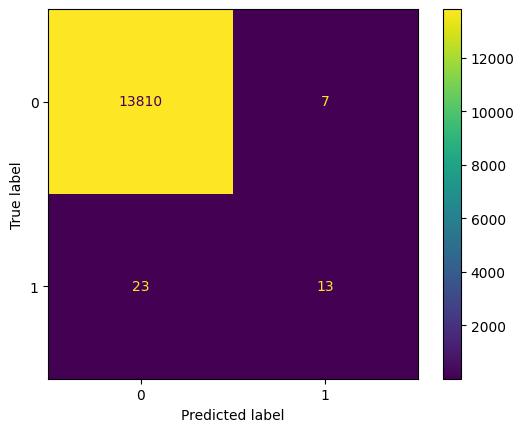

In [27]:
cm = confusion_matrix(y_test, y_pred_grid_rf, labels=grid_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_rf.classes_)
disp.plot()

In [29]:
print("Valores previstos: ", list(y_pred_grid_rf))
print("Valores reais: " , list(y_test))
print('========================================')
print('Tweets errados:')
index = -1
for x,y in zip(list(y_pred_grid_rf), list(y_test)):
    index +=1
    if x != y:
        print(df_test.tweet[index])

Valores previstos:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Logistic Regression

In [30]:
param_grid = {'C': [0.5, 1, 10, 100],
              'class_weight': ['balanced', None],
              'solver': ['lbfgs', 'liblinear']}

scorer = make_scorer(f1_score, pos_label = 1)

grid_lr = GridSearchCV(LogisticRegression(max_iter=10000),param_grid, verbose=3, cv=5, scoring=scorer)
grid_lr.fit(X_train_tfidf, y_train)
y_pred_grid_lr = grid_lr.predict(X_test_tfidf)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=0.5, class_weight=balanced, solver=lbfgs;, score=0.580 total time=   0.2s
[CV 2/5] END C=0.5, class_weight=balanced, solver=lbfgs;, score=0.643 total time=   0.2s
[CV 3/5] END C=0.5, class_weight=balanced, solver=lbfgs;, score=0.441 total time=   0.3s
[CV 4/5] END C=0.5, class_weight=balanced, solver=lbfgs;, score=0.581 total time=   0.2s
[CV 5/5] END C=0.5, class_weight=balanced, solver=lbfgs;, score=0.636 total time=   0.8s
[CV 1/5] END C=0.5, class_weight=balanced, solver=liblinear;, score=0.580 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, solver=liblinear;, score=0.643 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, solver=liblinear;, score=0.441 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, solver=liblinear;, score=0.581 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, solver=liblinear;, score=0.627 total time=   0.0s
[CV 1/5] END C=0.5, class_wei

In [33]:
best_est = grid_lr.best_estimator_
best_scores = grid_lr.cv_results_['mean_test_score'][grid_svm.best_index_]
print(best_scores)

0.5741512173636976


In [34]:
print(grid_lr.best_params_)
print(classification_report(y_test,y_pred_grid_lr))

{'C': 100, 'class_weight': 'balanced', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.90      0.75      0.82        36

    accuracy                           1.00     13853
   macro avg       0.95      0.87      0.91     13853
weighted avg       1.00      1.00      1.00     13853



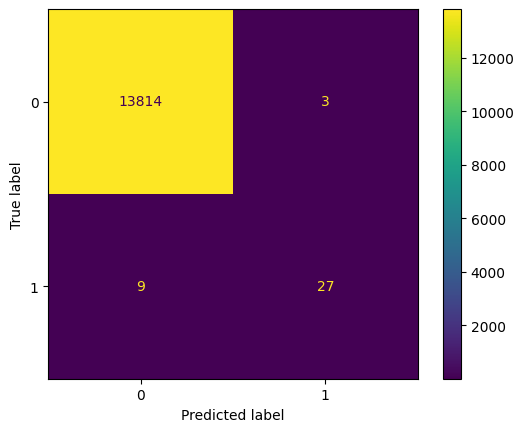

In [35]:
cm = confusion_matrix(y_test, y_pred_grid_lr, labels=grid_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_lr.classes_)
disp.plot()

Onde falha o modelo?

In [36]:
print("Valores previstos: ", list(y_pred_grid_lr))
print("Valores reais: " , list(y_test))
print('========================================')
print('Tweets errados:')
index = -1
for x,y in zip(list(y_pred_grid_lr), list(y_test)):
    index +=1
    if x != y:
        print(df_test.tweet[index])

Valores previstos:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Naive bayes

In [46]:
param_grid = {'alpha': [0, 0.01, 0.5, 1.0, 5, 10],
              'force_alpha':[True, False],
              'fit_prior': [True, False]}

scorer = make_scorer(f1_score, pos_label = 1)

grid_nb = GridSearchCV(MultinomialNB(), param_grid, scoring= scorer, verbose=3, cv=5)
grid_nb.fit(X_train_tfidf, y_train)
y_pred_grid_nb = grid_nb.predict(X_test_tfidf)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END alpha=0, fit_prior=True, force_alpha=True;, score=0.125 total time=   0.0s
[CV 2/5] END alpha=0, fit_prior=True, force_alpha=True;, score=0.188 total time=   0.0s
[CV 3/5] END alpha=0, fit_prior=True, force_alpha=True;, score=0.129 total time=   0.0s
[CV 4/5] END alpha=0, fit_prior=True, force_alpha=True;, score=0.067 total time=   0.0s
[CV 5/5] END alpha=0, fit_prior=True, force_alpha=True;, score=0.294 total time=   0.0s
[CV 1/5] END alpha=0, fit_prior=True, force_alpha=False;, score=0.154 total time=   0.0s
[CV 2/5] END alpha=0, fit_prior=True, force_alpha=False;, score=0.320 total time=   0.0s
[CV 3/5] END alpha=0, fit_prior=True, force_alpha=False;, score=0.245 total time=   0.0s
[CV 4/5] END alpha=0, fit_prior=True, force_alpha=False;, score=0.275 total time=   0.0s
[CV 5/5] END alpha=0, fit_prior=True, force_alpha=False;, score=0.222 total time=   0.0s
[CV 1/5] END alpha=0, fit_prior=False, force_alpha=Tr

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\Paulo Seixal\OneDrive - Universidade do

[CV 5/5] END alpha=0, fit_prior=False, force_alpha=False;, score=0.050 total time=   0.0s
[CV 1/5] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.372 total time=   0.0s
[CV 2/5] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.306 total time=   0.0s
[CV 3/5] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.310 total time=   0.0s
[CV 4/5] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.296 total time=   0.0s
[CV 1/5] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.372 total time=   0.0s
[CV 2/5] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.306 total time=   0.0s
[CV 3/5] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.310 total time=   0.0s
[CV 4/5] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.296 total time=   

In [48]:
print(grid_nb.best_params_)
print(classification_report(y_test,y_pred_grid_nb))

{'alpha': 0.01, 'fit_prior': True, 'force_alpha': True}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.94      0.47      0.63        36

    accuracy                           1.00     13853
   macro avg       0.97      0.74      0.81     13853
weighted avg       1.00      1.00      1.00     13853



In [39]:
best_est = grid_nb.best_estimator_
best_scores = grid_nb.cv_results_['mean_test_score'][grid_nb.best_index_]
print(best_scores)

0.3253322345788772


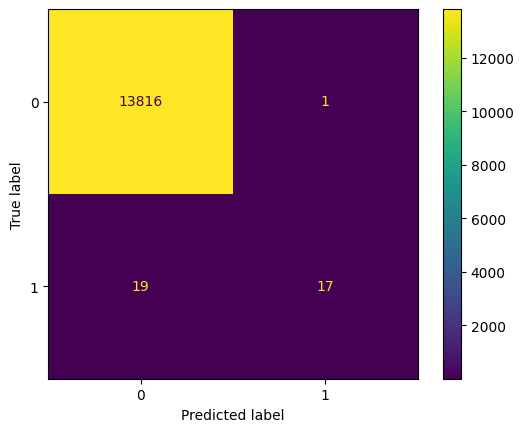

In [40]:
cm = confusion_matrix(y_test, y_pred_grid_nb, labels=grid_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_nb.classes_)
disp.plot()

### MPLClassifier

In [45]:
clf_mpl = MLPClassifier()
clf_mpl.fit(X_train_tfidf, y_train)
y_pred_mlp = clf_mpl.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_mlp))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.95      0.56      0.70        36

    accuracy                           1.00     13853
   macro avg       0.98      0.78      0.85     13853
weighted avg       1.00      1.00      1.00     13853



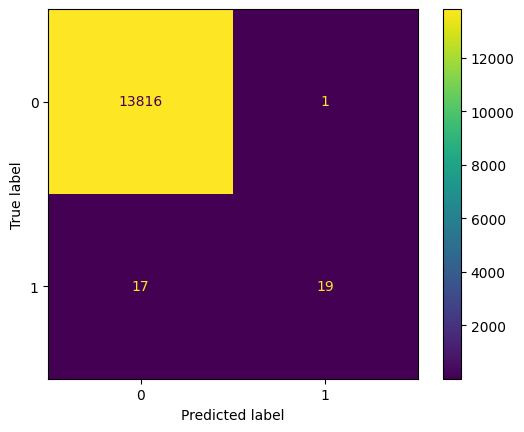

In [39]:
cm = confusion_matrix(y_test, y_pred_mlp, labels=clf_mpl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_mpl.classes_)
disp.plot()

In [40]:
print("Valores previstos: ", list(y_pred_mlp))
print("Valores reais: " , list(y_test))
score = 0
for x,y in zip(list(y_pred_mlp), list(y_test)):
    score +=1
    if x != y:
        print(score)

Valores previstos:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Ensemble

In [105]:
eclf = VotingClassifier(estimators=[('svm', grid_svm), ('lr', grid_lr)],
                        voting='hard', weights=[2,4])
eclf.fit(X_train_tfidf,y_train)
y_eclf_pred = eclf.predict(X_test_tfidf)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, class_weight=balanced, loss=hinge;, score=0.667 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, loss=hinge;, score=0.654 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, loss=hinge;, score=0.583 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, loss=hinge;, score=0.655 total time=   0.1s
[CV 5/5] END C=1, class_weight=balanced, loss=hinge;, score=0.717 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.691 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.720 total time=   0.1s
[CV 3/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.583 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.643 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, loss=squared_hinge;, score=0.745 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, loss=hinge;,

In [106]:
print(classification_report(y_test, y_eclf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.90      0.75      0.82        36

    accuracy                           1.00     13853
   macro avg       0.95      0.87      0.91     13853
weighted avg       1.00      1.00      1.00     13853



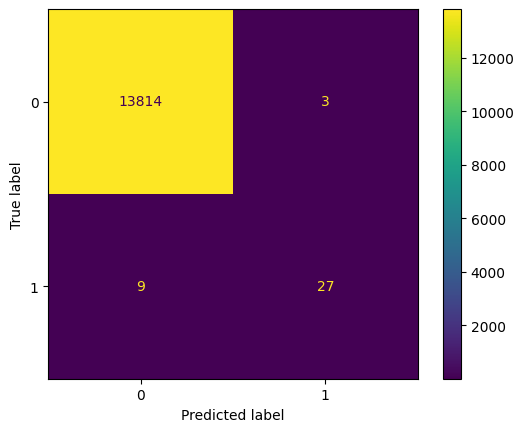

In [35]:
cm = confusion_matrix(y_test, y_eclf_pred, labels=eclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

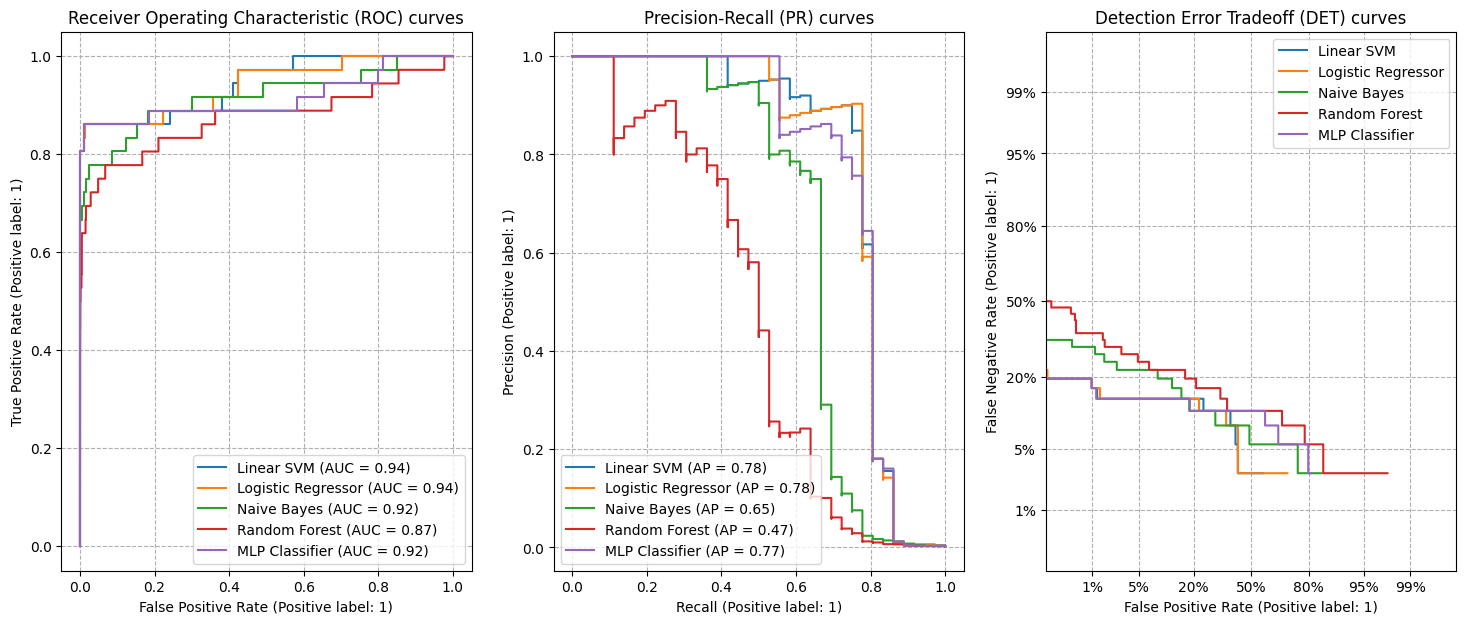

In [49]:

classifiers = {
    "Linear SVM": grid_svm.best_estimator_,
    "Logistic Regressor": grid_lr.best_estimator_,
    'Naive Bayes': grid_nb.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'MLP Classifier': clf_mpl
}

import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay

fig, [ax_roc, ax_pr, ax_det] = plt.subplots(1, 3, figsize=(18, 7))

for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)

    RocCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_roc, name=name)
    PrecisionRecallDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_pr, name=name)
    DetCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_pr.set_title("Precision-Recall (PR) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_pr.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()